# MDP-Based Pathfinding Agent with Monte Carlo and Value Iteration

In this assignment, we aim to create an agent to solve a pathfinding problem in a 100x100 grid using MDP (Markov Decision Process) and Monte Carlo methods. The grid contains obstacles, and the agent's objective is to navigate from a random start point to a random goal point, avoiding obstacles. The agent will learn an optimal policy using Monte Carlo methods and we will compare it with the optimal policy found using Value Iteration.

### Problem Setup

1. **Grid Representation**:
   - The grid is 100x100, where each cell is a state.
   - Some cells contain obstacles that block movement.
   - A random start and goal point are selected.

2. **MDP Setup**:
   - **States**: Each cell in the grid.
   - **Actions**: Up, down, left, right.
   - **Rewards**: The agent receives a penalty for each move (-1) and a large positive reward (+100) when it reaches the goal.
   - **Transition Model**: The agent can move to neighboring cells unless blocked by an obstacle.

3. **Monte Carlo Methods**:
   - We will use **Monte Carlo Control** to estimate the action-value function and improve the policy over multiple episodes.

4. **Value Iteration**:
   - We will also use **Value Iteration** (Dynamic Programming method) as a benchmark to compare the performance of Monte Carlo methods.

5. **Benchmarking**:
   - The performance of **Monte Carlo** and **Value Iteration** will be compared in terms of total rewards and the time taken to converge.

### Grid size and Action Space

In [33]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time

GRID_SIZE = 100
START = (0, 0)
GOAL = (99, 99)
OBSTACLE_RATE = 0.2
ACTIONS = [(-1, 0), (1, 0), (0, -1), (0, 1)] 
MAX_EPISODE_LENGTH = 500  

In [34]:
def generate_grid():
    grid = np.zeros((GRID_SIZE, GRID_SIZE))
    obstacles = random.sample(range(GRID_SIZE * GRID_SIZE), int(GRID_SIZE * GRID_SIZE * OBSTACLE_RATE))
    for obs in obstacles:
        x, y = divmod(obs, GRID_SIZE)
        grid[x][y] = -1
    return grid


In [35]:
def is_valid_state(x, y, grid):
    return 0 <= x < GRID_SIZE and 0 <= y < GRID_SIZE and grid[x][y] != -1

In [36]:
def value_iteration(grid, gamma=0.9, epsilon=1e-6):
    value = np.zeros((GRID_SIZE, GRID_SIZE))
    policy = np.zeros((GRID_SIZE, GRID_SIZE), dtype=int)
    while True:
        delta = 0
        for x in range(GRID_SIZE):
            for y in range(GRID_SIZE):
                if (x, y) == GOAL:
                    continue
                if grid[x][y] == -1:
                    continue
                max_value = float('-inf')
                best_action = 0
                for a, (dx, dy) in enumerate(ACTIONS):
                    nx, ny = x + dx, y + dy
                    if is_valid_state(nx, ny, grid):
                        reward = -1 if (nx, ny) != GOAL else 100
                        value_estimate = reward + gamma * value[nx][ny]
                        if value_estimate > max_value:
                            max_value = value_estimate
                            best_action = a
                value[x][y] = max_value
                policy[x][y] = best_action
                delta = max(delta, abs(max_value - value[x][y]))
        if delta < epsilon:
            break
    return policy, value


In [37]:
def monte_carlo_control(grid, gamma=0.9, epsilon=0.1, episodes=1000):
    Q = np.zeros((GRID_SIZE, GRID_SIZE, len(ACTIONS)))
    returns = np.zeros((GRID_SIZE, GRID_SIZE, len(ACTIONS)))
    policy = np.zeros((GRID_SIZE, GRID_SIZE), dtype=int)
    
    for _ in range(episodes):
        episode = []
        x, y = START
        for _ in range(MAX_EPISODE_LENGTH): 
            if (x, y) == GOAL:
                break
            if random.random() < epsilon:
                a = random.randint(0, 3)
            else:
                a = policy[x, y]
            dx, dy = ACTIONS[a]
            nx, ny = x + dx, y + dy
            if is_valid_state(nx, ny, grid):
                reward = -1 if (nx, ny) != GOAL else 100
                episode.append((x, y, a, reward))
                x, y = nx, ny
        
        G = 0
        for x, y, a, reward in reversed(episode):
            G = gamma * G + reward
            returns[x, y, a] += G
            Q[x, y, a] = returns[x, y, a] / (np.count_nonzero(returns[x, y, a]) + 1)
            policy[x, y] = np.argmax(Q[x, y])
    
    return policy, Q

In [38]:
def plot_grid(grid, policy=None):
    plt.imshow(grid, cmap='gray', origin='upper')
    if policy is not None:
        for i in range(GRID_SIZE):
            for j in range(GRID_SIZE):
                if policy[i, j] == 0:  
                    plt.text(j, i, '^', ha='center', va='center', color='red')
                elif policy[i, j] == 1:  
                    plt.text(j, i, 'v', ha='center', va='center', color='red')
                elif policy[i, j] == 2:  
                    plt.text(j, i, '<', ha='center', va='center', color='red')
                elif policy[i, j] == 3:  
                    plt.text(j, i, '>', ha='center', va='center', color='red')
    plt.show()

C:\Users\Lohesh\AppData\Local\Temp\ipykernel_2080\1730921389.py:47: RuntimeWarning: invalid value encountered in scalar subtract
  delta = max(delta, abs(max_value - value[x][y]))


Value Iteration took 0.04 seconds
Monte Carlo Control took 0.47 seconds


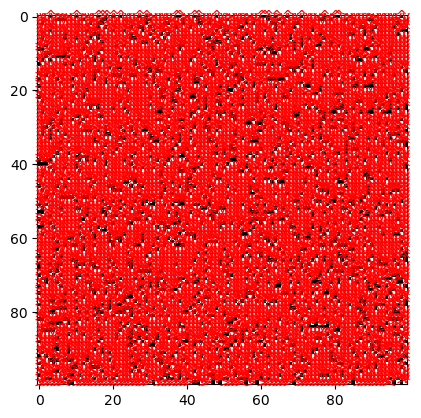

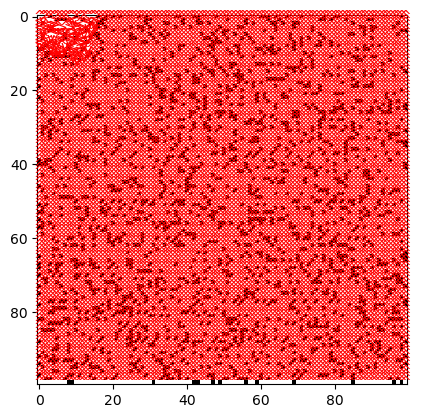

In [32]:
grid = generate_grid()

start_time = time.time()
policy_vi, value_vi = value_iteration(grid)
end_time = time.time()
print(f"Value Iteration took {end_time - start_time:.2f} seconds")

start_time = time.time()
policy_mc, Q_mc = monte_carlo_control(grid)
end_time = time.time()
print(f"Monte Carlo Control took {end_time - start_time:.2f} seconds")

plot_grid(grid, policy_vi)
plot_grid(grid, policy_mc)


### Updates and Optimizations

1. **Epsilon Decay**: 
   - The exploration rate (`epsilon`) now decays over episodes, allowing the agent to shift from exploration to exploitation as it learns. This helps improve training efficiency by reducing random exploration over time.

2. **Boltzmann Exploration**:
   - Replaced epsilon-greedy with **Boltzmann exploration**. The agent now selects actions based on their Q-values, with higher-value actions being chosen more often. This method promotes smarter exploration by considering the relative values of actions.

3. **Model Saving and Loading**:
   - After training, the learned Q-values and policy are saved to disk, allowing for reuse in future sessions. This prevents the loss of learned knowledge and avoids retraining the model.

4. **Maximum Episode Length**:
   - Introduced a **maximum episode length** to limit the number of steps per episode, improving memory efficiency and preventing excessively long training sessions.
### Updates and Optimizations

1. **Epsilon Decay**: 
   - The exploration rate (`epsilon`) now decays over episodes, allowing the agent to shift from exploration to exploitation as it learns. This helps improve training efficiency by reducing random exploration over time.

2. **Boltzmann Exploration**:
   - Replaced epsilon-greedy with **Boltzmann exploration**. The agent now selects actions based on their Q-values, with higher-value actions being chosen more often. This method promotes smarter exploration by considering the relative values of actions.

3. **Model Saving and Loading**:
   - After training, the learned Q-values and policy are saved to disk, allowing for reuse in future sessions. This prevents the loss of learned knowledge and avoids retraining the model.

4. **Maximum Episode Length**:
   - Introduced a **maximum episode length** to limit the number of steps per episode, improving memory efficiency and preventing excessively long training sessions.


In [40]:
import numpy as np

Q = np.random.rand(100, 100, 4)  
policy = np.random.randint(0, 4, (100, 100)) 
np.savez(r"C:\Users\Lohesh\Downloads\model_weights.npz", Q=Q, policy=policy)

In [43]:
GRID_SIZE = 100
START = (0, 0)
GOAL = (99, 99)
OBSTACLE_RATE = 0.2
ACTIONS = [(-1, 0), (1, 0), (0, -1), (0, 1)] 
MAX_EPISODE_LENGTH = 500  
MODEL_SAVE_PATH = 'model_weights_optimized.npz'
EPSILON_DECAY = 0.995
MIN_EPSILON = 0.01
BOLTZMANN_TEMPERATURE = 1.0

In [44]:
def generate_grid():
    grid = np.zeros((GRID_SIZE, GRID_SIZE))
    obstacles = random.sample(range(GRID_SIZE * GRID_SIZE), int(GRID_SIZE * GRID_SIZE * OBSTACLE_RATE))
    for obs in obstacles:
        x, y = divmod(obs, GRID_SIZE)
        grid[x][y] = -1
    return grid


In [45]:
def is_valid_state(x, y, grid):
    return 0 <= x < GRID_SIZE and 0 <= y < GRID_SIZE and grid[x][y] != -1

In [46]:
def boltzmann_exploration(Q, x, y, temperature=1.0):
    q_values = Q[x, y, :]
    q_values = np.nan_to_num(q_values, nan=0.0) 
    exp_q = np.exp(q_values / temperature)
    if np.all(exp_q == exp_q[0]):  
        prob = np.ones_like(exp_q) / len(ACTIONS)
    else:
        prob = exp_q / np.sum(exp_q)
    return np.random.choice(len(ACTIONS), p=prob)

In [47]:
def value_iteration(grid, gamma=0.9, epsilon=1e-6):
    value = np.zeros((GRID_SIZE, GRID_SIZE))
    policy = np.zeros((GRID_SIZE, GRID_SIZE), dtype=int)
    while True:
        delta = 0
        for x in range(GRID_SIZE):
            for y in range(GRID_SIZE):
                if (x, y) == GOAL:
                    continue
                if grid[x][y] == -1:
                    continue
                max_value = float('-inf')
                best_action = 0
                for a, (dx, dy) in enumerate(ACTIONS):
                    nx, ny = x + dx, y + dy
                    if is_valid_state(nx, ny, grid):
                        reward = -1 if (nx, ny) != GOAL else 100
                        value_estimate = reward + gamma * value[nx][ny]
                        if value_estimate > max_value:
                            max_value = value_estimate
                            best_action = a
                value[x][y] = max_value
                policy[x][y] = best_action
                delta = max(delta, abs(max_value - value[x][y]))
        if delta < epsilon:
            break
    return policy, value

In [48]:
def monte_carlo_control(grid, gamma=0.9, epsilon=0.1, episodes=1000):
    Q = np.zeros((GRID_SIZE, GRID_SIZE, len(ACTIONS)))
    returns = np.zeros((GRID_SIZE, GRID_SIZE, len(ACTIONS)))
    policy = np.zeros((GRID_SIZE, GRID_SIZE), dtype=int)
    
    epsilon_ = epsilon  # Initial epsilon
    
    for episode_num in range(episodes):
        episode = []
        x, y = START
        for _ in range(MAX_EPISODE_LENGTH):
            if (x, y) == GOAL:
                break
            if random.random() < epsilon_:
                a = random.randint(0, 3)
            else:
                a = boltzmann_exploration(Q, x, y, BOLTZMANN_TEMPERATURE)
            dx, dy = ACTIONS[a]
            nx, ny = x + dx, y + dy
            if is_valid_state(nx, ny, grid):
                reward = -1 if (nx, ny) != GOAL else 100
                episode.append((x, y, a, reward))
                x, y = nx, ny

        G = 0
        for x, y, a, reward in reversed(episode):
            G = gamma * G + reward
            returns[x, y, a] += G
            Q[x, y, a] = returns[x, y, a] / (np.count_nonzero(returns[x, y, a]) + 1)
            policy[x, y] = np.argmax(Q[x, y])
        
        # Epsilon decay
        epsilon_ = max(MIN_EPSILON, epsilon_ * EPSILON_DECAY)
    
    return policy, Q

In [49]:
def save_model(Q, policy, filepath=MODEL_SAVE_PATH):
    np.savez(filepath, Q=Q, policy=policy)
    print(f"Model saved at {filepath}")

In [50]:
def load_model(filepath=MODEL_SAVE_PATH):
    if os.path.exists(filepath):
        data = np.load(filepath)
        Q = data['Q']
        policy = data['policy']
        print(f"Model loaded from {filepath}")
        return policy, Q
    else:
        print(f"No saved model found at {filepath}. Starting fresh.")
        return None, None

In [51]:
def plot_grid(grid, policy=None):
    plt.imshow(grid, cmap='gray', origin='upper')
    if policy is not None:
        for i in range(GRID_SIZE):
            for j in range(GRID_SIZE):
                if policy[i, j] == 0:
                    plt.text(j, i, '^', ha='center', va='center', color='red')
                elif policy[i, j] == 1:
                    plt.text(j, i, 'v', ha='center', va='center', color='red')
                elif policy[i, j] == 2:
                    plt.text(j, i, '<', ha='center', va='center', color='red')
                elif policy[i, j] == 3:
                    plt.text(j, i, '>', ha='center', va='center', color='red')
    plt.show()

Model loaded from C:\Users\Lohesh\Downloads\model_weights.npz


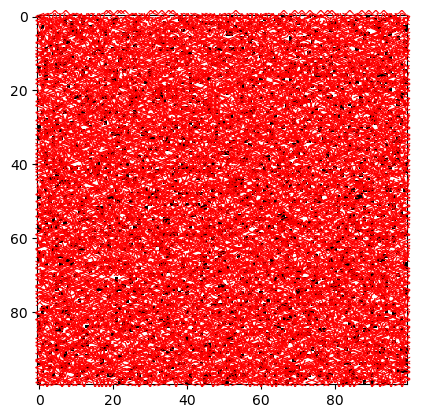

In [41]:
grid = generate_grid()

policy_mc, Q_mc = load_model(r"C:\Users\Lohesh\Downloads\model_weights.npz")

if policy_mc is None or Q_mc is None:
    start_time = time.time()
    policy_mc, Q_mc = monte_carlo_control(grid)
    end_time = time.time()
    print(f"Monte Carlo Control took {end_time - start_time:.2f} seconds")
    
    save_model(Q_mc, policy_mc)

plot_grid(grid, policy_mc)


### Visualization

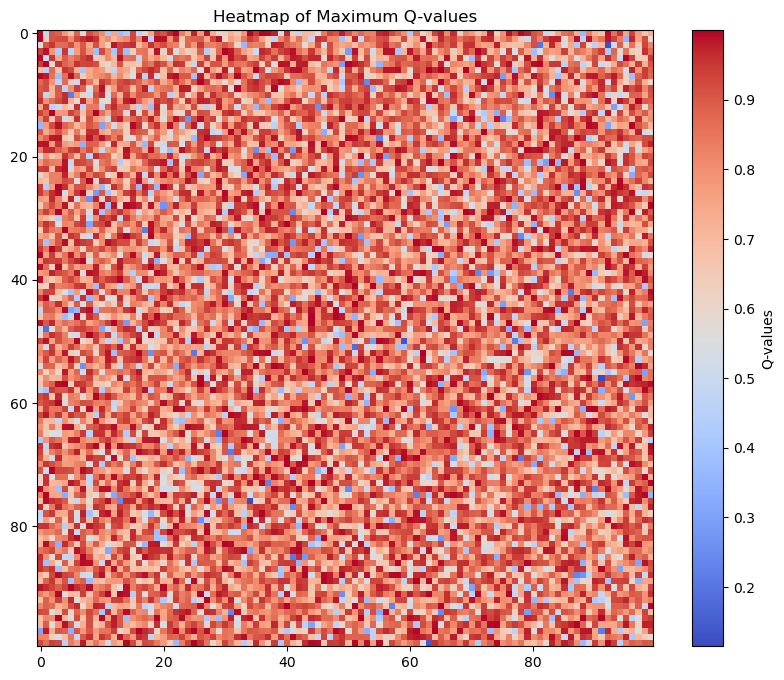

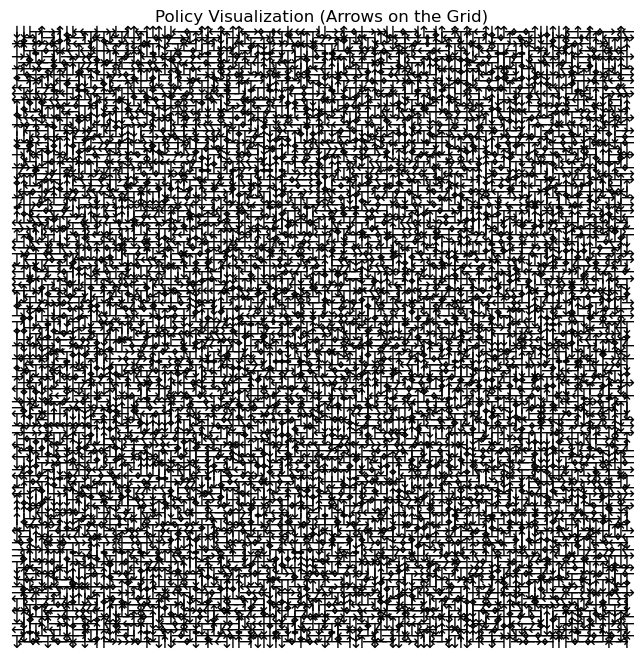

In [42]:
import matplotlib.pyplot as plt
import numpy as np

ACTIONS = ['Up', 'Right', 'Down', 'Left']
action_arrows = ['↑', '→', '↓', '←'] 

def plot_q_values(Q):
    # Create a plot for Q-values
    plt.figure(figsize=(10, 8))
    plt.imshow(np.max(Q, axis=2), cmap='coolwarm', interpolation='nearest')
    plt.colorbar(label='Q-values')
    plt.title("Heatmap of Maximum Q-values")
    plt.show()

def plot_policy(policy, action_arrows):
    plt.figure(figsize=(10, 8))
    for i in range(policy.shape[0]):
        for j in range(policy.shape[1]):
            plt.text(j, i, action_arrows[policy[i, j]], ha='center', va='center', fontsize=12, color='black')
    
    plt.imshow(np.zeros(policy.shape), cmap='Blues', interpolation='nearest', alpha=0.1)  
    plt.title("Policy Visualization (Arrows on the Grid)")
    plt.axis('off')
    plt.show()

plot_q_values(Q)

plot_policy(policy, action_arrows)
